In [79]:
import csv
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
import mglearn
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE 
from scipy.stats import itemfreq

In [80]:
%matplotlib inline

### Reading the CSV file and cleaning

feature dataframe has the features read except for the first (seq_num) and the last column (label)
The dataframe also drop the Glucose column and replaces all NaN values and 7,9 (in labels) to 0

Features were also normalized - (features - features.mean())/features.std()

In [81]:
df = pd.read_csv('../Data/new_nhanes.csv')
df = df.iloc[:, 1:]

# replace string values with integers
df['Gender'] = df['Gender'].map({'female': 1, 'male': 0})
df['Diabetes'] = df['Diabetes'].map({'Yes': 1, 'No': 0})

# dropping all NaN in the dataframe
df = df.dropna(axis=0, how='any')

#Age more than 20
df = df[df.Age > 19]

print "Cleaned label counts:"
print df.groupby('Diabetes').size()

#separating features and labels
features = df.iloc[:, 0:-1]
label = df.iloc[:,-1]

print "\n"
print "Columns in the features"
column_names = list(features)
print column_names

# #normalizing features - unnormalized also results in similar results
normalized_features = (features - features.mean())/(features.max() - features.min())

Cleaned label counts:
Diabetes
0.0    5700
1.0     633
dtype: int64


Columns in the features
['Gender', 'Age', 'BMI', 'Weight', 'Height', 'TotChol', 'BPSys1', 'BPDia1']


#### Pair Plot of Normalized Features - Red Diabetic, Blue Normal

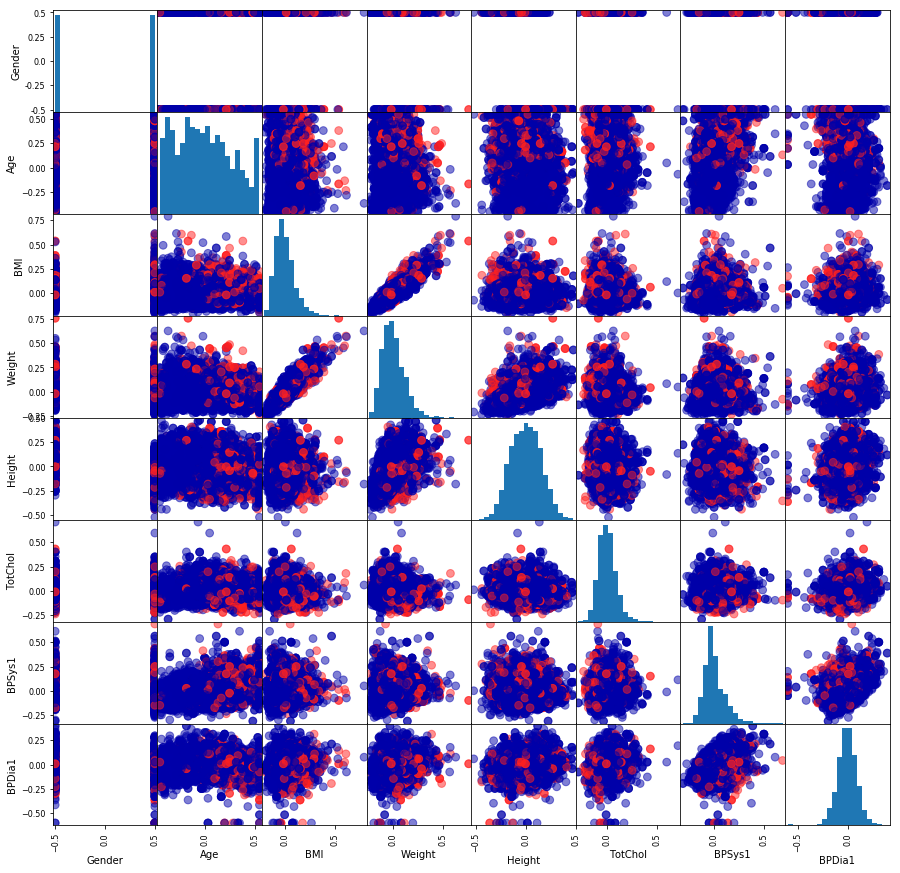

In [82]:
# create a scatter matrix from the dataframe, color by y
grr = pd.scatter_matrix(normalized_features, c=label, figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.5, cmap=mglearn.cm2)

### Formatting input for Machine Learning

#### Original Data

In [83]:
# X = features.as_matrix()
X = normalized_features.as_matrix()

Y = label.as_matrix()

print "Shape of the original matrices"
print X.shape
print Y.shape

print "\n"
print "Total unique counts by labels - original"
print np.unique(Y, return_counts=True)

print "\n"
print "Total unique counts by labels - SMOTE"
print np.unique(Y_res, return_counts=True)

# 70% training and 30% test 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print "\n"
print "Total unique counts by labels for training and testing"
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print np.unique(y_train, return_counts=True)
print np.unique(y_test, return_counts=True)

Shape of the original matrices
(6333, 8)
(6333,)


Total unique counts by labels - original
(array([ 0.,  1.]), array([5700,  633]))


Total unique counts by labels - SMOTE
(array([ 0.,  1.]), array([5700,  633]))


Total unique counts by labels for training and testing
(4433, 'train sequences')
(1900, 'test sequences')
(array([ 0.,  1.]), array([3994,  439]))
(array([ 0.,  1.]), array([1706,  194]))


#### Over-Sampled SMOTE Data - On Training only

In [84]:
sm = SMOTE(random_state=42)

x_train_o_sam, y_train_o_sam = sm.fit_sample(x_train, y_train)

print "\n"
print "Total unique counts by labels for training and testing - Sampled"
print(len(x_train_o_sam), 'train sequences')

print np.unique(y_train_o_sam, return_counts=True)



Total unique counts by labels for training and testing - Sampled
(7988, 'train sequences')
(array([ 0.,  1.]), array([3994, 3994]))


#### Pair Plot of Normalized Features of Sampled Data - Red Diabetic, Blue Normal

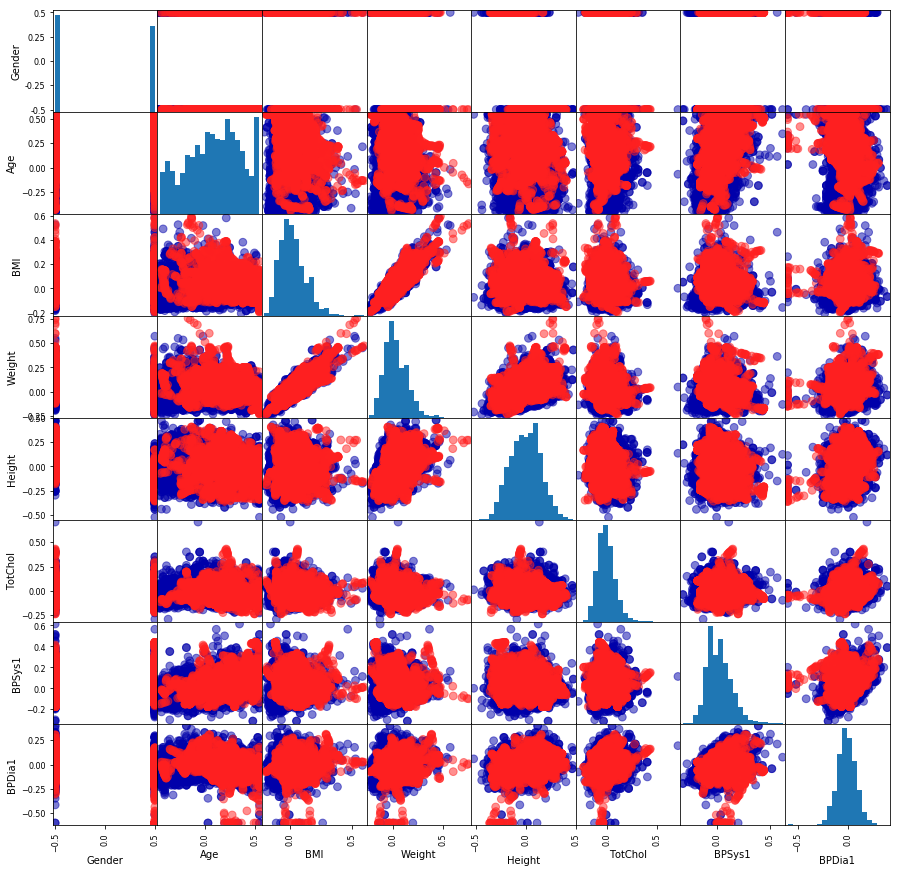

In [85]:
# create a scatter matrix from the dataframe, color by y
sampled_df = pd.DataFrame(x_train_o_sam)
sampled_df.columns = column_names

sampled_label = pd.DataFrame(y_train_o_sam)

# print sampled_df
grr = pd.scatter_matrix(sampled_df, c=sampled_label, figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.5, cmap=mglearn.cm2)

#### Comparision with Decision Trees and Random Forest 

#### Decision Tree Classifier

Decision Tree
             precision    recall  f1-score   support

     Normal       0.95      0.90      0.93      1706
   Diabetic       0.40      0.58      0.47       194

avg / total       0.89      0.87      0.88      1900

Confusion matrix, without normalization
[[1539  167]
 [  82  112]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.868947368421
Precision:  0.893462274354
Recall:  0.868947368421


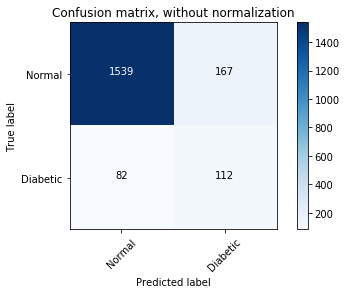

In [86]:
import itertools
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# These are the tuned paramters

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def decision_tree(feat_train, feat_test, label_train, label_test):
    clf = tree.DecisionTreeClassifier(class_weight=None,
                                      criterion='gini', splitter='best')
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Normal', 'Diabetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('Decision Tree')
accuracy,precision,recall = decision_tree(x_train_o_sam, x_test, y_train_o_sam, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall


#### Random Forest

In [87]:
def random_forest(feat_train, feat_test, label_train, label_test, num_estimators):
    clf = RandomForestClassifier(n_estimators=num_estimators, max_features=None, 
                                 class_weight='balanced', oob_score=True)

    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    result['oob_error'] = oob_error = 1 - clf.oob_score_
    target_names = ['Normal', 'Daibetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall'], result['oob_error']

#### Random Forest with 50 trees

Random forest
             precision    recall  f1-score   support

     Normal       0.94      0.99      0.96      1706
   Daibetic       0.81      0.41      0.54       194

avg / total       0.92      0.93      0.92      1900

Confusion matrix, without normalization
[[1687   19]
 [ 115   79]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.929473684211
Precision:  0.922902253255
Recall:  0.929473684211


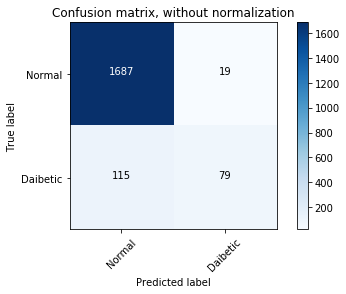

In [89]:
print("Random forest")
accuracy,precision,recall,oob_score = random_forest(x_train, x_test, y_train, y_test, 50)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest with 500 trees without oversampled training data

Random forest
             precision    recall  f1-score   support

     Normal       0.94      0.99      0.96      1706
   Daibetic       0.82      0.40      0.54       194

avg / total       0.92      0.93      0.92      1900

Confusion matrix, without normalization
[[1689   17]
 [ 116   78]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.93
Precision:  0.924024493366
Recall:  0.93


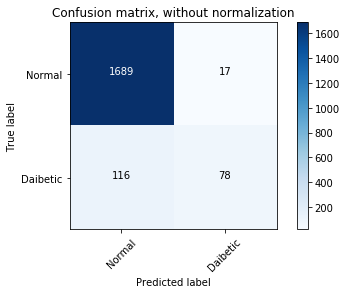

In [90]:
print("Random forest")
accuracy,precision,recall,oob_score = random_forest(x_train, x_test, y_train, y_test, 500)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest - 500 with Over-Sampled Training

Random forest
             precision    recall  f1-score   support

     Normal       0.95      0.94      0.95      1706
   Daibetic       0.52      0.60      0.56       194

avg / total       0.91      0.90      0.91      1900

Confusion matrix, without normalization
[[1598  108]
 [  77  117]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.902631578947
Precision:  0.909713118617
Recall:  0.902631578947


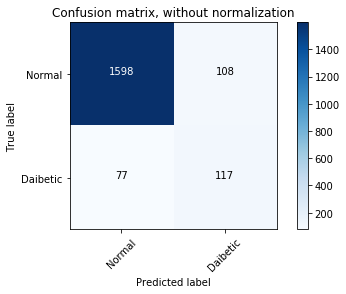

In [92]:
print("Random forest")
accuracy,precision,recall,oob_scorel = random_forest(x_train_o_sam, x_test, y_train_o_sam, y_test, 500)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest - 500 Out-Of-Bag (OOB) Training Error - Non-Sampled Data

Random forest
             precision    recall  f1-score   support

     Normal       0.94      0.99      0.96      1706
   Daibetic       0.81      0.41      0.54       194

avg / total       0.92      0.93      0.92      1900

Confusion matrix, without normalization
[[1687   19]
 [ 115   79]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Training Error:  0.0597789307467
Accuracy:  0.929473684211
Precision:  0.922902253255
Recall:  0.929473684211


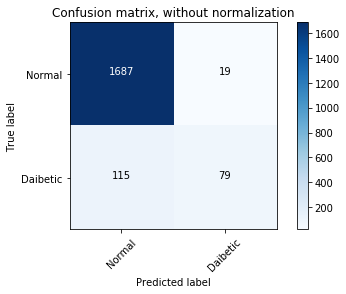

In [70]:
print("Random forest")
accuracy,precision,recall,oob_score = random_forest(x_train, x_test, y_train, y_test, 500)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Training Error: ", oob_score
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest - 500 Out-Of-Bag (OOB) Training Error - Sampled Data

Random forest
             precision    recall  f1-score   support

     Normal       0.95      0.94      0.94      1706
   Daibetic       0.51      0.59      0.55       194

avg / total       0.91      0.90      0.90      1900

Confusion matrix, without normalization
[[1598  108]
 [  80  114]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Training Error:  0.0464446670005
Accuracy:  0.901052631579
Precision:  0.907519315313
Recall:  0.901052631579


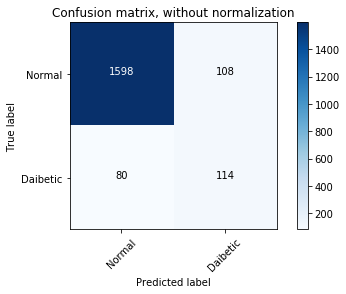

In [93]:
print("Random forest")
accuracy,precision,recall,oob_score = random_forest(x_train_o_sam, x_test, y_train_o_sam, y_test, 500)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Training Error: ", oob_score
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest - 500 Out-Of-Bag (OOB) Training Error - Non-Sampled Data

Random forest
             precision    recall  f1-score   support

     Normal       0.94      0.99      0.96      1706
   Daibetic       0.83      0.41      0.55       194

avg / total       0.93      0.93      0.92      1900

Confusion matrix, without normalization
[[1690   16]
 [ 115   79]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Training Error:  0.0609068351004
Accuracy:  0.931052631579
Precision:  0.925596734218
Recall:  0.931052631579


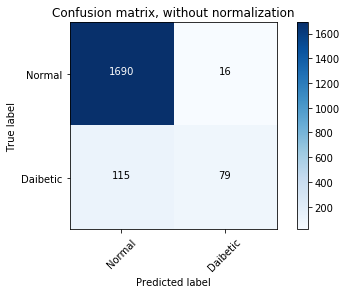

In [94]:
print("Random forest")
accuracy,precision,recall,oob_score = random_forest(x_train, x_test, y_train, y_test, 500)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Training Error: ", oob_score
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest with 1000 trees

Random forest
             precision    recall  f1-score   support

     Normal       0.95      0.94      0.95      1706
   Daibetic       0.52      0.57      0.55       194

avg / total       0.91      0.90      0.90      1900

Confusion matrix, without normalization
[[1604  102]
 [  83  111]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.902631578947
Precision:  0.906928313713
Recall:  0.902631578947


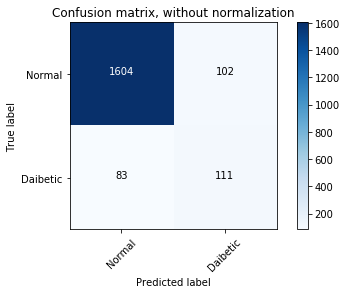

In [21]:
print("Random forest")
accuracy,precision,recall = random_forest(x_train, x_test, y_train, y_test, 1000)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Random Forest with 10000 trees

Random forest
             precision    recall  f1-score   support

     Normal       0.95      0.94      0.95      1706
   Daibetic       0.53      0.57      0.55       194

avg / total       0.91      0.90      0.91      1900

Confusion matrix, without normalization
[[1606  100]
 [  83  111]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.903684210526
Precision:  0.907484982354
Recall:  0.903684210526


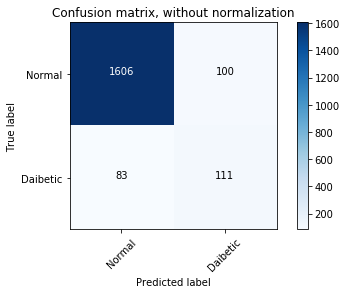

In [24]:
print("Random forest")
accuracy,precision,recall = random_forest(x_train, x_test, y_train, y_test, 10000)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Grid Search Random Forest - Parameter Tuning

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

tuned_parameters = [
    {
        'n_estimators': [100,200,1000, 2000],
        'criterion': ['gini', 'entropy'],
        "bootstrap": [True, False],
        'max_features': ['auto', 'sqrt', 'log2', None],
        'max_depth': [5, 10, 15, 30, 50, None],
        'min_samples_leaf': [1, 10, 30, 50, 100],
        'n_jobs': [8]
    }
]

clf = GridSearchCV(RandomForestClassifier(), param_grid=tuned_parameters, n_jobs=8, verbose=1)

clf.fit(X_res, Y_res)

print(clf.best_params_)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(clf.cv_results_)

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  6.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 12.3min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 19.9min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 28.5min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 39.8min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 52.9min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 69.4min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 87.8min
[Parallel(n_jobs=8)]: Done 5760 out of 5760 | elapsed: 104.5min finished


{'n_jobs': 8, 'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 200, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10}
Model with rank: 1
Mean validation score: 0.905 (std: 0.004)
Parameters: {'n_jobs': 8, 'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 200, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.903 (std: 0.004)
Parameters: {'n_jobs': 8, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 100, 'criterion': 'gini', 'max_features': 'auto', 'max_depth': 30}

Model with rank: 2
Mean validation score: 0.903 (std: 0.005)
Parameters: {'n_jobs': 8, 'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 1000, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 15}

Model with rank: 2
Mean validation score: 0.903 (std: 0.005)
Parameters: {'n_jobs': 8, 'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 2000, 'criterion': 'entropy', 'max_features': 'sqrt', 'max

Random forest
             precision    recall  f1-score   support

     Normal       0.95      0.95      0.95      1706
   Daibetic       0.55      0.56      0.55       194

avg / total       0.91      0.91      0.91      1900

Confusion matrix, without normalization
[[1615   91]
 [  85  109]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.907368421053
Precision:  0.908647368421
Recall:  0.907368421053


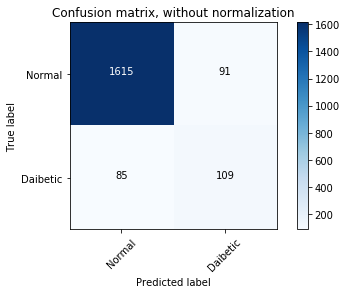

In [60]:
def random_forest(feat_train, feat_test, label_train, label_test, num_estimators):
    clf = RandomForestClassifier(bootstrap = False, n_estimators = 200, criterion = 'entropy', 
                                 max_features = 'sqrt', max_depth = None)
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    target_names = ['Normal', 'Daibetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']
                                 
print("Random forest")
accuracy,precision,recall = random_forest(x_train_o_sam, x_test, y_train_o_sam, y_test, 200)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

## Other Classifiers - Extra Tree, Logistic Regression, Gradient Boosting, SVM, KNN

#### Extra-Tree Classifier

In [74]:
from sklearn.ensemble import ExtraTreesClassifier
def xtree_forest(feat_train, feat_test, label_train, label_test, num_estimators):
    clf = ExtraTreesClassifier(n_estimators=num_estimators, max_depth=None)

    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    target_names = ['Normal', 'Daibetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

Extra-Tree Classifier
             precision    recall  f1-score   support

     Normal       0.95      0.94      0.95      1706
   Daibetic       0.53      0.57      0.55       194

avg / total       0.91      0.90      0.91      1900

Confusion matrix, without normalization
[[1607   99]
 [  84  110]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.903684210526
Precision:  0.907031653646
Recall:  0.903684210526


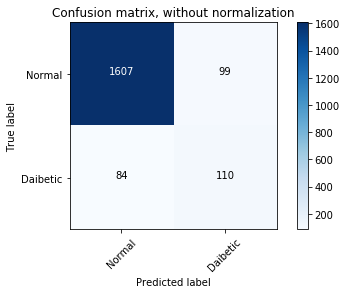

In [78]:
print("Extra-Tree Classifier")
accuracy,precision,recall = xtree_forest(x_train_o_sam, x_test, y_train_o_sam, y_test, 200)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### Logistic Regression Classifier

In [ ]:
def log_reg(feat_train, feat_test, label_train, label_test):
    clf = linear_model.LogisticRegression(class_weight='balanced')
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Normal', 'Daibetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('Logistic Regression')
accuracy,precision,recall = log_reg(x_train, x_test, y_train, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall


#### Gradient Boosting Classifier

Grandient Boosting Classifier
             precision    recall  f1-score   support

     Normal       0.94      0.97      0.96      1706
   Daibetic       0.63      0.50      0.56       194

avg / total       0.91      0.92      0.91      1900

Confusion matrix, without normalization
[[1649   57]
 [  97   97]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.918947368421
Precision:  0.912324751272
Recall:  0.918947368421


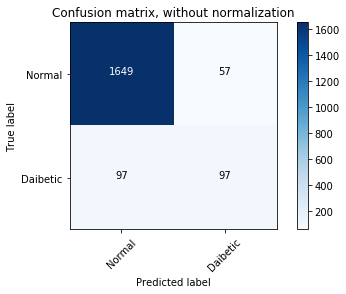

In [63]:
from sklearn.ensemble import GradientBoostingClassifier
def gbc(feat_train, feat_test, label_train, label_test):
    clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.2, 
                                     max_leaf_nodes=100, max_depth=None, random_state=0, 
                                     warm_start=True)
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Normal', 'Daibetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('Grandient Boosting Classifier')
accuracy,precision,recall = gbc(x_train_o_sam, x_test, y_train_o_sam, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### SVM Classifier

SVM
             precision    recall  f1-score   support

     Normal       0.93      1.00      0.96      1706
   Diabetic       0.93      0.36      0.52       194

avg / total       0.93      0.93      0.92      1900

Confusion matrix, without normalization
[[1701    5]
 [ 124   70]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.932105263158
Precision:  0.932185340062
Recall:  0.932105263158


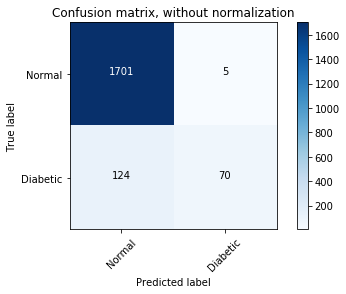

In [22]:
from sklearn.svm import SVC
def svm(feat_train, feat_test, label_train, label_test):
    clf = SVC(kernel='rbf',class_weight='balanced')
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Normal', 'Diabetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('SVM')
accuracy,precision,recall = svm(x_train, x_test, y_train, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall

#### K-Nearest Neighbor Classifier

KNeighborsClassifier
             precision    recall  f1-score   support

     Normal       0.95      0.83      0.89      1706
   Diabetic       0.30      0.64      0.41       194

avg / total       0.89      0.81      0.84      1900

Confusion matrix, without normalization
[[1423  283]
 [  70  124]]


Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix
Accuracy:  0.814210526316
Precision:  0.886904761554
Recall:  0.814210526316


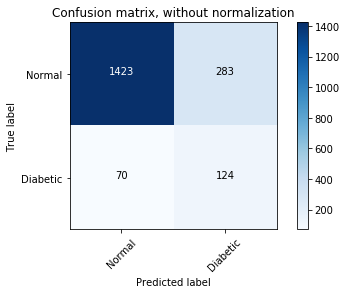

In [23]:
from sklearn.neighbors import KNeighborsClassifier
def knn(feat_train, feat_test, label_train, label_test):
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(feat_train, label_train)
    predicted_labels = clf.predict(feat_test)
    label_test = np.array(label_test)
    result = {}
    result['recall'] = recall_score(label_test, predicted_labels,
                                    average='weighted')
    result['accuracy'] = accuracy_score(label_test, predicted_labels)
    result['precision'] = precision_score(label_test, predicted_labels,
                                          average='weighted')
    
    target_names = ['Normal', 'Diabetic']
    
    print(classification_report(label_test, predicted_labels, target_names=target_names))
    
    cnf_matrix = confusion_matrix(label_test, predicted_labels)
    plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')
    
    return result['accuracy'], result['precision'], result['recall']

print('KNeighborsClassifier')
accuracy,precision,recall = knn(x_train, x_test, y_train, y_test)
print "\n"
print "Overall Accuracy figures - Biased by Normal as shown above and below by confusion matrix"
print "Accuracy: ", accuracy
print "Precision: ", precision
print "Recall: ", recall